# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


## Model Choice

A random forest model is chosen as the baseline model due to its efficiency in grasping more complex situation for binary or multi-class classification tasks. The aim is to see if patterns in the data can be processed into meaningful results by a relatively simple model.


## Feature Selection

The features selected are based on their relevance to predicting Navigational Status. These include:
- Speed over Ground (SOG): Vessel speed, which varies significantly across statuses.
- Course over Ground (COG): Direction of the vessel.
- Heading: Indicates the vessel's orientation.

The target variable is Navigational Status.

## Implementation

[Implement your baseline model here.]




Accuracy: 0.8198

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       913
           1       0.86      0.85      0.86      1562

    accuracy                           0.82      2475
   macro avg       0.81      0.81      0.81      2475
weighted avg       0.82      0.82      0.82      2475



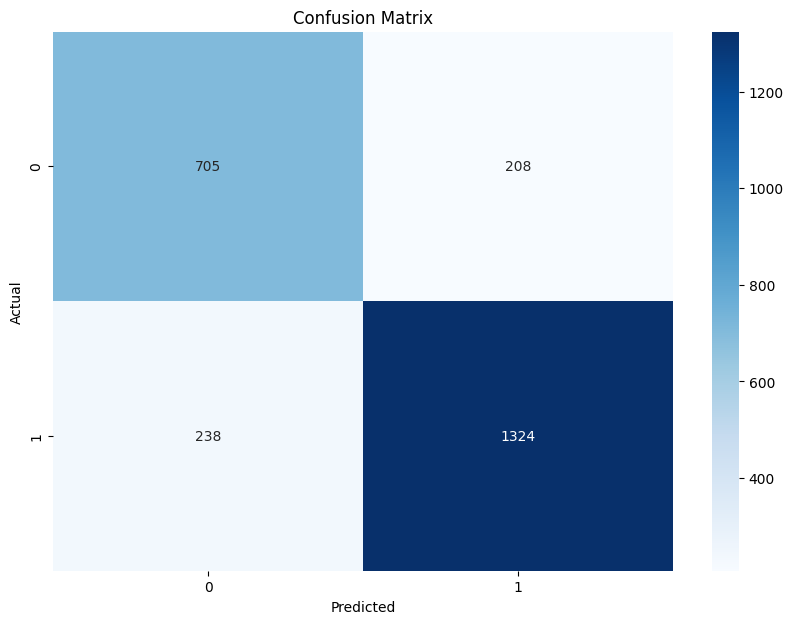


Feature Importance:
            Feature  Importance
0          SOG_mean    0.311026
1           SOG_std    0.117213
3       COG_sin_std    0.087154
7   Heading_sin_std    0.084415
9   Heading_cos_std    0.075433
4      COG_cos_mean    0.074285
8  Heading_cos_mean    0.068017
5       COG_cos_std    0.066069
6  Heading_sin_mean    0.061747
2      COG_sin_mean    0.054641


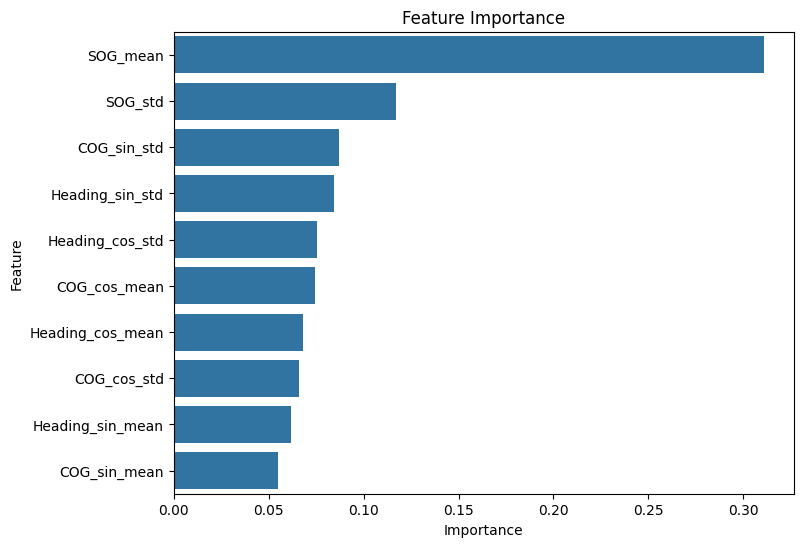


Cross-validation Accuracy: 0.8295 ± 0.0119


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the folder containing 15-minute set files
data_folder = './time_sets_standardized'

# Initialize lists to store aggregated data
aggregated_features = []
file_labels = []

# Loop through all CSV files in the folder
for file in os.listdir(data_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_csv(file_path)

        # Ensure the required columns exist
        required_columns = ['SOG', 'COG', 'Heading', 'Navigational status']
        if all(col in df.columns for col in required_columns):
            # Drop rows with missing values
            df = df.dropna(subset=required_columns)

            # Subtract the initial COG to normalize starting course to 0
            initial_cog = df['COG'].iloc[0]
            df['COG'] = (df['COG'] - initial_cog) % 360
            df['Heading'] = (df['Heading'] - initial_cog) % 360

            # Apply cyclical encoding for COG and Heading
            df['COG_sin'] = np.sin(np.deg2rad(df['COG']))
            df['COG_cos'] = np.cos(np.deg2rad(df['COG']))
            df['Heading_sin'] = np.sin(np.deg2rad(df['Heading']))
            df['Heading_cos'] = np.cos(np.deg2rad(df['Heading']))

            # Determine the label for the file: use the most frequent "Navigational status"
            if not df['Navigational status'].empty:
                file_label = df['Navigational status'].mode()[0]  # Take the mode as the file's label
                
                # Only include files with the desired navigational statuses
                if file_label in ['Under way using engine', 'Engaged in fishing']:
                    aggregated_data = {
                        'SOG_mean': df['SOG'].mean(),
                        'SOG_std': df['SOG'].std(),
                        'COG_sin_mean': df['COG_sin'].mean(),
                        'COG_sin_std': df['COG_sin'].std(),
                        'COG_cos_mean': df['COG_cos'].mean(),
                        'COG_cos_std': df['COG_cos'].std(),
                        'Heading_sin_mean': df['Heading_sin'].mean(),
                        'Heading_sin_std': df['Heading_sin'].std(),
                        'Heading_cos_mean': df['Heading_cos'].mean(),
                        'Heading_cos_std': df['Heading_cos'].std(),
                    }

                    aggregated_features.append(aggregated_data)
                    file_labels.append(file_label)
        else:
            print(f"Skipping {file}, missing required columns.")

# Create a DataFrame from aggregated features
feature_df = pd.DataFrame(aggregated_features)
feature_df['Navigational status'] = file_labels

# Filter to only include the two target classes
feature_df = feature_df[feature_df['Navigational status'].isin(['Under way using engine', 'Engaged in fishing'])]

# Encode the target variable (categorical to numeric)
feature_df['Navigational status'] = feature_df['Navigational status'].astype('category').cat.codes

# Feature selection: use only the selected features
features = feature_df.columns[:-1]  # Exclude the target column
target = 'Navigational status'

# Define feature matrix (X) and target vector (y)
X = feature_df[features]
y = feature_df[target]

# Split the dataset into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
if hasattr(model, "feature_importances_"):
    importance = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\nFeature Importance:")
    print(importance_df)

    # Visualize feature importance
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance')
    plt.show()

# Optional: Cross-validation scores for the model
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


## Evaluation

Evaluation

To evaluate the baseline model:

- Accuracy: Proportion of correct predictions out of all predictions.
- Classification Report: Includes precision, recall, and F1-score for each class, providing detailed insights into model performance.
- Confusion Matrix: Displays actual vs. predicted values to analyze performance for each class.

Example Output:

- Accuracy: Indicates the overall performance.
- Confusion Matrix: Highlights areas where the model misclassified.
- Classification Report: Shows per-class performance metrics, aiding in identifying underperforming categories.

